In [20]:
import numpy as np  # whole numpy lib is available, prepend 'np.'
from numpy import average, std
from numpy.random import random, randint, normal, shuffle,uniform
import scipy
from scipy.stats import ttest_ind
import seaborn as sns
import fnmatch
import os  # handy system and path functions
import sys  # to get file system encoding
import csv
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd  
import matplotlib
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)
import mne
#import FOOOF
from mne.time_frequency import tfr_morlet

Python version 2.7.15 |Anaconda, Inc.| (default, Dec 14 2018, 19:04:19) 
[GCC 7.3.0]
Pandas version 0.23.4
Matplotlib version 2.2.3


In [2]:
ROOT='/data/backed_up/shared/ThalHi_data/eeg_preproc/'

In [5]:
all_subs_cue={}
all_subs_probe={}
all_subs_resp={}
for sub in os.listdir(ROOT):
    if sub !='73': # sub 73 is the file with the 1 missing event
        this_sub_path=ROOT+sub
        all_subs_cue[sub]=mne.read_epochs(this_sub_path+'/cue-epo.fif')
        all_subs_probe[sub]=mne.read_epochs(this_sub_path+'/probe events-epo.fif')
        all_subs_resp[sub]=mne.read_epochs(this_sub_path+'/response events-epo.fif')

Reading /data/backed_up/shared/ThalHi_data/eeg_preproc/86/cue-epo.fif ...
    Found the data of interest:
        t =    -800.78 ...    1500.00 ms
        0 CTF compensation matrices available
415 matching events found
Applying baseline correction (mode: mean)
415 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
0 projection items activated
Reading /data/backed_up/shared/ThalHi_data/eeg_preproc/86/probe events-epo.fif ...
    Found the data of interest:
        t =    -800.78 ...    3000.00 ms
        0 CTF compensation matrices available
415 matching events found
Applying baseline correction (mode: mean)
415 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
0 projection items activated
Reading /data/backed_up/shared/ThalHi_data/eeg_preproc/86/response events-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
415 ma

415 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
0 projection items activated
Reading /data/backed_up/shared/ThalHi_data/eeg_preproc/96/cue-epo.fif ...
    Found the data of interest:
        t =    -800.78 ...    1500.00 ms
        0 CTF compensation matrices available
403 matching events found
Applying baseline correction (mode: mean)
403 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
0 projection items activated
Reading /data/backed_up/shared/ThalHi_data/eeg_preproc/96/probe events-epo.fif ...
    Found the data of interest:
        t =    -800.78 ...    3000.00 ms
        0 CTF compensation matrices available
385 matching events found
Applying baseline correction (mode: mean)
385 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 18 columns
0 projection items activated
Reading /data/backed_up/shared/ThalHi_data/eeg_preproc/96/response events-epo.fif 

In [10]:
all_subs_cue # i forgot that Emily's triggers were not well thought out... 

{'70': <EpochsFIF  |   412 events (all good), -0.800781 - 1.5 sec, baseline [-0.800781, -0.3], ~241.1 MB, data loaded, with metadata,
  u'EDS_trig': 98
  u'IDS_trig': 100
  u'Stay_trig': 214>,
 '76': <EpochsFIF  |   415 events (all good), -0.800781 - 1.5 sec, baseline [-0.800781, -0.3], ~242.8 MB, data loaded, with metadata,
  u'EDS_trig': 100
  u'IDS_trig': 100
  u'Stay_trig': 215>,
 '80': <EpochsFIF  |   414 events (all good), -0.800781 - 1.5 sec, baseline [-0.800781, -0.3], ~242.2 MB, data loaded, with metadata,
  u'EDS_trig': 100
  u'IDS_trig': 99
  u'Stay_trig': 215>,
 '82': <EpochsFIF  |   407 events (all good), -0.800781 - 1.5 sec, baseline [-0.800781, -0.3], ~238.1 MB, data loaded, with metadata,
  u'EDS_trig': 98
  u'IDS_trig': 100
  u'Stay_trig': 209>,
 '86': <EpochsFIF  |   415 events (all good), -0.800781 - 1.5 sec, baseline [-0.800781, -0.3], ~242.8 MB, data loaded, with metadata,
  u'EDS_trig': 100
  u'IDS_trig': 100
  u'Stay_trig': 215>,
 '88': <EpochsFIF  |   411 events

## Organizing emily's data more properly... lol

In [11]:
all_subs_cue['Em'].metadata.reset_index(drop=True).iloc[81]

cue                 none
Color               none
Texture             none
Shape               none
Task                none
cue_stim            none
Trial_type          none
pic                 none
pic_stim            none
img_path            none
trial_Corr            -1
rt                     0
What_Is_CorrResp      -1
Subject_Respo         -1
trial_n               82
block                  1
sub                   em
trigs               none
Name: 81, dtype: object

In [14]:
#all_subs_cue['Em'].metadata

In [12]:
Em_cue=all_subs_cue['Em'].drop([81,162,245,327,410])
#the indices of the 83rd trial of each block, which didn't get recorded into the beahvioral csv bc of a bug--since fixed

Dropped 5 epochs


In [15]:
behav=Em_cue.metadata.reset_index(drop=True)
stay_inds=behav[behav.Trial_type=='Stay'].index
IDS_inds=behav[behav.Trial_type=='IDS'].index
EDS_inds=behav[behav.Trial_type=='EDS'].index
stay_eps=Em_cue.copy()[stay_inds]
IDS_eps=Em_cue.copy()[IDS_inds]
EDS_eps=Em_cue.copy()[EDS_inds]

In [33]:
len(EDS_eps.times)

1179

### tfr_morlet outputs an mne object that contains time-freq data, can either be a trial-averaged array or can retain single-trial info, here i'm averaging over trials

In [93]:
freqs = np.logspace(*np.log10([2, 35]), num=20)
n_cycles = freqs / 2.  # different number of cycle per frequency
power_stay, itc = tfr_morlet(stay_eps, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

In [94]:
power_stay.data.shape # shape= (n_channels,n_freqs,n_times)

(64, 20, 393)

In [95]:
power_IDS, itc = tfr_morlet(IDS_eps, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

In [79]:
#a=np.concatenate((power_IDS.data,power_stay.data))
#b=np.mean(a,axis=0)

In [105]:
stay_copy=np.expand_dims(power_stay.data,axis=0)
stay_copy.shape
#stay_copy

(1, 64, 20, 393)

In [108]:
IDS_copy=np.expand_dims(power_IDS.data,axis=0)
#IDS_copy

In [100]:
a=np.concatenate((stay_copy,IDS_copy))
b=np.mean(a,axis=0)

# Seperating into conditions, averaging across subs, and extracting Fz & PO

In [18]:
all_subs_cue.keys()

['Em', '76', '95', '91', '88', '70', '82', '80', '86', '94', '96']

In [127]:
stays=[]
IDSs=[]
EDSs=[]
tfr_stay={}
tfr_IDS={}
tfr_EDS={}
for sub in all_subs_cue.keys():
    sub_dat=all_subs_cue[sub]
    if sub !='Em':
        stay=sub_dat['Stay_trig']
        IDS=sub_dat['IDS_trig']
        EDS=sub_dat['EDS_trig']
    elif sub=='Em':
        stay=stay_eps
        IDS=IDS_eps
        EDS=EDS_eps
    stay_power,itc=tfr_morlet(stay, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1)
    IDS_power,itc=tfr_morlet(IDS, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1)
    EDS_power,itc=tfr_morlet(EDS, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                            return_itc=True, decim=3, n_jobs=1)

    #stay_copy=np.expand_dims(stay_power.data,axis=0)
    #IDS_copy=np.expand_dims(IDS_power.data,axis=0)
    #EDS_copy=np.expand_dims(EDS_power.data,axis=0)
    stays.append(stay_copy)
    IDSs.append(IDS_copy)
    EDSs.append(EDS_copy)
    tfr_stay[sub]=stay_power
    tfr_IDS[sub]=IDS_power
    tfr_EDS[sub]=EDS_power
    print(sub)

Em
76
95
91
88
70
82
80
86
94
96


In [136]:
stay_array=np.concatenate(stays,axis=0)
IDS_array=np.concatenate(IDSs,axis=0)
EDS_array=np.concatenate(EDSs,axis=0)
stay_avg=np.mean(stay_array,axis=0)
IDS_avg=np.mean(IDS_array,axis=0)
EDS_avg=np.mean(EDS_array,axis=0)

In [151]:
stay_avg.shape


(64, 20, 393)

In [144]:
stay_power.__init__

<bound method AverageTFR.__init__ of <AverageTFR  |  time : [-0.800781, 1.496094], freq : [2.000000, 35.000000], nave : 211, channels : 64, ~4.0 MB>>

In [145]:
all_stays=stay_power.copy()

In [146]:
all_stays.data=stay_avg

In [159]:
all_stays.ch_names.index('POz')

29

In [152]:
#all_stays.data

In [153]:
all_IDSs=IDS_power.copy()
all_IDSs.data=IDS_avg
all_EDSs=EDS_power.copy()
all_EDSs.data=EDS_avg

Applying baseline correction (mode: zscore)


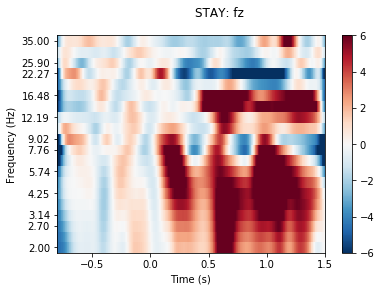

Applying baseline correction (mode: zscore)


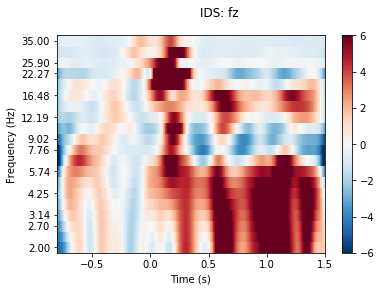

Applying baseline correction (mode: zscore)


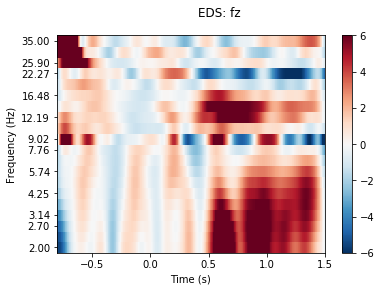

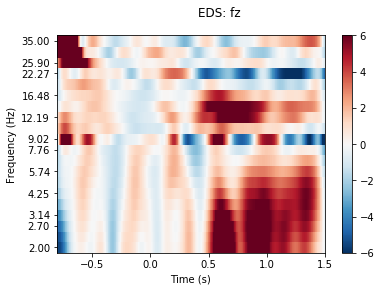

In [155]:
all_stays.plot([37],vmin=-6, vmax=6, baseline=(-0.5,0), mode='zscore', title='STAY: fz')
all_IDSs.plot([37],vmin=-6, vmax=6, baseline=(-0.5,0), mode='zscore', title='IDS: fz')
all_EDSs.plot([37],vmin=-6, vmax=6, baseline=(-0.5,0), mode='zscore', title='EDS: fz')

Applying baseline correction (mode: zscore)


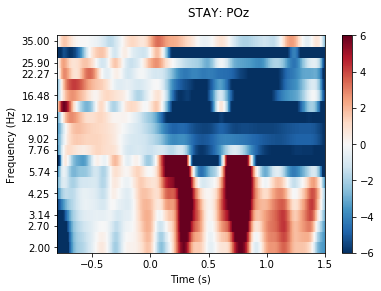

Applying baseline correction (mode: zscore)


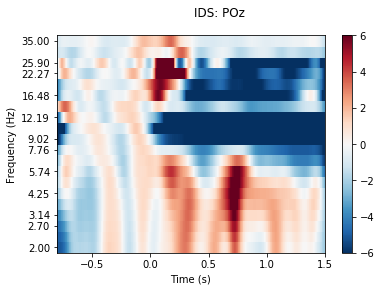

Applying baseline correction (mode: zscore)


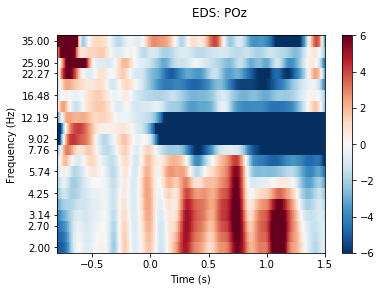

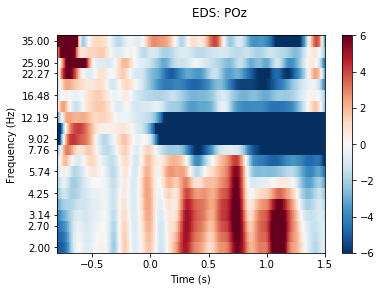

In [160]:
all_stays.plot([29],vmin=-6, vmax=6, baseline=(-0.5,0), mode='zscore', title='STAY: POz')
all_IDSs.plot([29],vmin=-6, vmax=6, baseline=(-0.5,0), mode='zscore', title='IDS: POz')
all_EDSs.plot([29],vmin=-6, vmax=6, baseline=(-0.5,0), mode='zscore', title='EDS: POz')

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


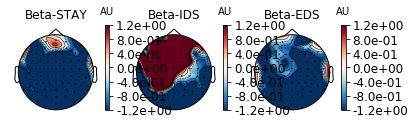

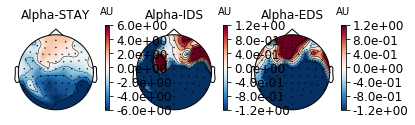

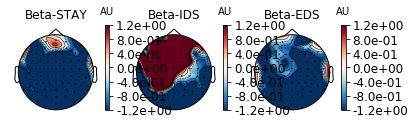

In [163]:
fig1, axis1 = plt.subplots(1, 3)
fig2,axis2=plt.subplots(1,3)
#fig3,axis3=plt.subplots(1,2)

all_stays.plot_topomap(ch_type='eeg', tmin=0.0, tmax=2, fmin=8, fmax=14, vmin=-6, vmax=6,
                   baseline=(-0.5, 0), mode='zscore', axes=axis1[0],
                   title='Alpha-STAY', show=False)
all_IDSs.plot_topomap(ch_type='eeg', tmin=0.0, tmax=2, fmin=8, fmax=14,vmin=-6, vmax=6,
                   baseline=(-0.5, 0), mode='zscore', axes=axis1[1],
                   title='Alpha-IDS', show=False)
all_EDSs.plot_topomap(ch_type='eeg', tmin=0.0, tmax=2, fmin=8, fmax=14,vmin=-6, vmax=6,
                   baseline=(-0.5, 0), mode='zscore', axes=axis1[2],
                   title='Alpha-EDS', show=False)
all_stays.plot_topomap(ch_type='eeg', tmin=0.0, tmax=2, fmin=18, fmax=25,vmin=-1.2, vmax=1.2,
                   baseline=(-0.5, 0), mode='zscore', axes=axis2[0],
                   title='Beta-STAY', show=False)
all_IDSs.plot_topomap(ch_type='eeg', tmin=0.0, tmax=2, fmin=18, fmax=25,vmin=-1.2, vmax=1.2,
                   baseline=(-0.5, 0), mode='zscore', axes=axis2[1],
                   title='Beta-IDS', show=False)
all_EDSs.plot_topomap(ch_type='eeg', tmin=0.0, tmax=2, fmin=18, fmax=25,vmin=-1.2, vmax=1.2,
                   baseline=(-0.5, 0), mode='zscore', axes=axis2[2],
                   title='Beta-EDS', show=False)